In [3]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon

import contextily as ctx
import earthpy as et
import earthpy.plot as ep
from earthpy import clip as cl

import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

In [4]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [5]:
# Download Data stored on figshare
# Free flowing rivers current DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273213")

# Free flowing rivers future DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273216")

# WDPA Africa
et.data.get_data(url="https://ndownloader.figshare.com/files/23354894")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

# Continent-country csv
et.data.get_data(url="https://ndownloader.figshare.com/files/23393756")

'/home/jovyan/earth-analytics/data/earthpy-downloads/continent-country.csv'

In [69]:
# Custon Function 1
def all_pa_country(wdpa_polys, ramsar_polys, country_name):
    """ This function takes a country name, WDPA polygons, and Ramsar Polygons, and returns a multipolygon feature of 
    the World Database of Protected Areas merged with the ramsar areas for that country.

    Parameters
    ----------
    country_name: str
        Three letter country code for the country to be analyzed.
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected country.
    ramsar_polys: gdf
        The feature with the ramsar polygons for the selected country.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the country.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["PARENT_ISO"] == country_name]
    wdpa_polys = wdpa_polys[wdpa_polys["PARENT_ISO"] == country_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [70]:
# Custon Function 2
def all_pa_continent(wdpa_polys, ramsar_polys, cont_name):
    """ This function takes WDPA polygons for a continent and global ramsar polygons and returns a multipolygon feature 
    of the World Database of Protected Areas merged with the ramsar areas for that continent.

    Parameters
    ----------
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected continent.
    ramsar_polys: gdf
        The feature with all global ramsar polygons.
    cont_name: str
        The name of the selected continent.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the continent.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["continent"] == cont_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [71]:
# Open continent & country borders & ISOs
country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))

continent_iso = pd.read_csv(os.path.join(wd_path, "earthpy-downloads",
                                         "continent-country.csv"))

continent_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-poly",
                                               "Continents.shp"))
# Open ramsar areas
ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Rename ramsar columns to match WDPA
try:
    ramsar_polys = ramsar_polys.rename(
        columns={"iso3": "PARENT_ISO", "officialna": "NAME", "area_off": "Shape_Area"})
except:
    print('Ramsar column names already match WDPA dataset.')

# Merge continent names with ramsar data for analyzing by continent
ramsar_polys = pd.merge(ramsar_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

In [ ]:
# Open current DOR shapefiles
dor_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "DOR_Binned", "DOR_0to5.shp"))
dor_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "DOR_Binned", "DOR_5to10.shp"))
dor_10to15 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_10to15.shp"))
dor_15to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_15to20.shp"))
dor_over20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_over20.shp"))
# Open planned DOR shapefiles
dor_pla_0to5 = gpd.read_file(os.path.join(wd_path,
                                          "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_0to5.shp"))
dor_pla_5to10 = gpd.read_file(os.path.join(wd_path,
                                           "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_5to10.shp"))
dor_pla_10to15 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_10to15.shp"))
dor_pla_15to20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_15to20.shp"))
dor_pla_over20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_over20.shp"))

In [11]:
# For loop to (1) calculating difference in DOR between planned and current, (2) pulling only rivers with class > 3,
# (3) projecting rivers, (4) buffer by 1/100 km to become polys for overlay fuction, (5) pull only needed columns

gdf_list = [dor_0to5, dor_5to10, dor_10to15, dor_15to20, dor_over20, dor_pla_0to5, dor_pla_5to10, dor_pla_10to15,
            dor_pla_15to20, dor_pla_over20]
river_list_prj = []

for shp in gdf_list:
    shp['DOR_DIFF'] = shp['DOR_PLA'] - shp['DOR']
    shp = shp[shp.RIV_CLASS > 3]
    shp = shp.to_crs('epsg:4087')
    shp['geometry'] = shp.buffer(10)
    shp = shp[['LENGTH_KM', 'RIV_ORD', 'RIV_CLASS', 'CONTINENT',
               'ISO_NAME', 'BAS_NAME', 'DOR', 'DOR_PLA', 'DOR_DIFF', 'Shape_Leng', 'geometry']]
    river_list_prj.append(shp)

# Re-assign names based on list index
dor_0to5 = river_list_prj[0]
dor_5to10 = river_list_prj[1]
dor_10to15 = river_list_prj[2]
dor_15to20 = river_list_prj[3]
dor_over20 = river_list_prj[4]

dor_pla_0to5 = river_list_prj[5]
dor_pla_5to10 = river_list_prj[6]
dor_pla_10to15 = river_list_prj[7]
dor_pla_15to20 = river_list_prj[8]
dor_pla_over20 = river_list_prj[9]

# Concatanate all rivers gdfs for easier analysis
all_rivers = pd.concat([dor_0to5, dor_5to10, dor_10to15,
                        dor_15to20, dor_over20], axis=0)

In [58]:
# Open WDPA polygons
wdpa_sa_polys = gpd.read_file(os.path.join(wd_path,
                                           "earthpy-downloads", "WDPA_S_America", "WDPA_S_America.shp"))

# wdpa_europe_polys = gpd.read_file(os.path.join(wd_path,
#                                                "earthpy-downloads", "WDPA_Europe", "WDPA_Europe.shp"))

# wdpa_na_polys = gpd.read_file(os.path.join(wd_path,
#                                            "earthpy-downloads", "WDPA_N_America", "WDPA_N_America.shp"))

# wdpa_africa_polys = gpd.read_file(os.path.join(wd_path,
#                                                "earthpy-downloads", "WDPA_Africa", "WDPA_Africa.shp"))

# wdpa_asia_polys = gpd.read_file(os.path.join(wd_path,
#                                              "earthpy-downloads", "WDPA_Asia", "WDPA_Asia.shp"))

# wdpa_aus_polys = gpd.read_file(os.path.join(wd_path,
#                                             "earthpy-downloads", "WDPA_Australia", "WDPA_Australia.shp"))

In [79]:
# Data cleaning - remove polygons with no area & take only the needed columns from WDPA dataset
# Would do this as a for loop but running all continents kills the kernel
wdpa_sa_polys = wdpa_sa_polys[wdpa_sa_polys.geometry != None]

# Merge continent names with WDPA data for analyzing by continent
wdpa_sa_polys = pd.merge(wdpa_sa_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

wdpa_sa_polys = wdpa_sa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'Shape_Area', 'continent_y', 'geometry']]

# wdpa_europe_polys = wdpa_europe_polys[wdpa_europe_polys.geometry != None]
# wdpa_europe_polys = wdpa_europe_polys[[
#     'NAME', 'DESIG', 'PARENT_ISO', 'Shape_Area', 'geometry']]

# wdpa_africa_polys = wdpa_africa_polys[wdpa_africa_polys.geometry != None]
# wdpa_africa_polys = wdpa_africa_polys[[
#     'NAME', 'DESIG', 'PARENT_ISO', 'geometry']]

# wdpa_na_polys = wdpa_na_polys[wdpa_na_polys.geometry != None]
# wdpa_na_polys = wdpa_na_polys[[
#     'NAME', 'DESIG', 'PARENT_ISO','Shape_Area', 'geometry']]

# wdpa_asia_polys = wdpa_asia_polys[wdpa_asia_polys.geometry != None]
# wdpa_asia_polys = wdpa_asia_polys[[
#     'NAME', 'DESIG', 'PARENT_ISO', 'Shape_Area', 'geometry']]

# wdpa_aus_polys = wdpa_aus_polys[wdpa_aus_polys.geometry != None]
# wdpa_aus_polys = wdpa_aus_polys[[
#     'NAME', 'DESIG', 'PARENT_ISO','Shape_Area',  'geometry']]

In [14]:
# Reproject all data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
# Would do this as a for loop but running all continents kills the kernel
ramsar_polys = ramsar_polys.to_crs('epsg:4087')
country_borders = country_borders.to_crs('epsg:4087')
continent_borders = continent_borders.to_crs('epsg:4087')

wdpa_sa_polys = wdpa_sa_polys.to_crs('epsg:4087')
# wdpa_europe_polys = wdpa_europe_polys.to_crs('epsg:4087')
# wdpa_africa_polys = wdpa_africa_polys.to_crs('epsg:4087')
# wdpa_na_polys = wdpa_na_polys.to_crs('epsg:4087')
# wdpa_asia_polys = wdpa_asia_polys.to_crs('epsg:4087')
# wdpa_aus_polys = wdpa_aus_polys.to_crs('epsg:4087')

In [ ]:
# Merge continent names with ramsar data for analyzing by continent
ramsar_polys = pd.merge(ramsar_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

In [15]:
# Analyze length and area affected on a continent
# Get the combined WDPA & ramsar areas for selected continent
# Would do as for loop but running all continents kills kernel

wdpa_ramsar_sa = all_pa_continent(wdpa_sa_polys, ramsar_polys, "South America")
# wdpa_ramsar_euro = all_pa_continent(wdpa_europe_polys, ramsar_polys, "Europe")
# wdpa_ramsar_na = all_pa_continent(wdpa_na_polys, ramsar_polys, "North America")
# wdpa_ramsar_africa = all_pa_continent(wdpa_africa_polys, ramsar_polys, "Africa")
# wdpa_ramsar_asia = all_pa_continent(wdpa_asia_polys, ramsar_polys, "Asia")
# wdpa_ramsar_aus = all_pa_continent(wdpa_aus_polys, ramsar_polys, "Oceania")

In [17]:
# Remove rivers that have DOR_DIFF of 0
all_rivers_lg = all_rivers[all_rivers.DOR_DIFF > 0]

# Getting river length affected
# Overlay current rivers on protected areas for selected continent to get ONLY rivers the overlap PAs
river_overlap_sa = gpd.overlay(
    wdpa_ramsar_sa, all_rivers_lg, how='intersection')

# Getting protected areas affected
# Overlay protected rivers on rivers for selected continent to get ONLY pas that overlap rivers
pa_overlap_sa = gpd.overlay(
    river_overlap_sa, wdpa_ramsar_sa, how='intersection')

In [ ]:
# Get a list of countries in each continent for calculating lengths/areas by country later
sa_countries = continent_iso[continent_iso.continent == 'South America']
# africa_countries = continent_iso[continent_iso.continent == 'Africa']
# na_countries = continent_iso[continent_iso.continent == 'North America']
# asia_countries = continent_iso[continent_iso.continent == 'Asia']
# europe_countries = continent_iso[continent_iso.continent == 'Europe']
# aus_countries = continent_iso[continent_iso.continent == 'Oceania']

# # Get continent borders for plotting later
# sa_border = continent_borders[continent_borders['CONTINENT']
#                               == "South America"]
# africa_border = continent_borders[continent_borders['CONTINENT'] == "Africa"]
# na_border = continent_borders[continent_borders['CONTINENT']
#                               == "North America"]
# asia_border = continent_borders[continent_borders['CONTINENT'] == "Asia"]
# europe_border = continent_borders[continent_borders['CONTINENT'] == "Europe"]
# aus_border = continent_borders[continent_borders['CONTINENT'] == "Australia"]

In [ ]:
# Rename ramsar columns to match WDPA
try:
    ramsar_polys = ramsar_polys.rename(
        columns={"iso3": "PARENT_ISO", "officialna": "NAME", "area_off": "Shape_Area"})
except:
    print('Ramsar column names already match WDPA dataset.')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

In [29]:
# Create empty lists
country_sums = []
area_sums = []
countries = []

# Sum up the total river length affected by country in the continent
for country in sa_countries.ISO3:
    country_sums.append(
        river_overlap_sa.loc[river_overlap_sa['PARENT_ISO'] == country, 'LENGTH_KM'].sum())
    area_sums.append(
        pa_overlap_sa.loc[pa_overlap_sa['PARENT_ISO_1'] == country, 'Shape_Area_1'].sum())
    countries.append(country)

 # Create a pandas dataframe of lengths and areas affected
sa_affected = pd.DataFrame(list(zip(countries, country_sums, area_sums)), columns=[
                           'Country', 'Affected_KM', 'Affected_Area'])

In [39]:
# Calculated for one country only to create a country example plot
# Get the combined WDPA & ramsar areas for seleced country
wdpa_ramsar_ven = all_pa_country('VEN', wdpa_sa_polys, ramsar_polys)

# Get country borders for plotting
ven_border = country_borders[country_borders['CNTRY_NAME'] == "Venezuela"]

# Clip to only get current rivers in Brazil
try:
    all_rivers_0to5_ven = gpd.clip(dor_0to5, ven_border)
except:
    print("No rivers of 0-5 DOR.")
try:
    all_rivers_5to10_ven = gpd.clip(dor_0to5, ven_border)
except:
    print("No rivers of 5-10 DOR.")
try:
    all_rivers_10to15_ven = gpd.clip(dor_0to5, ven_border)
except:
    print("No rivers of 10-15 DOR.")
try:
    all_rivers_15to20_ven = gpd.clip(dor_0to5, ven_border)
except:
    print("No rivers of 15-20 DOR.")
try:
    all_rivers_over20_ven = gpd.clip(dor_0to5, ven_border)
except:
    print("No rivers of over 20 DOR.")

No ramsar areas in WDPA dataset.
No duplicates in the WDPA dataset.


In [40]:
# Overlay current rivers on protected areas for Brazil
rivers_0to5_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_0to5, how='intersection')
rivers_5to10_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_5to10, how='intersection')
rivers_10to15_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_10to15, how='intersection')
rivers_15to20_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_15to20, how='intersection')
rivers_over20_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_over20, how='intersection')

# Overlay proposed rivers on protected areas for Brazil
rivers_pla_0to5_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_pla_0to5, how='intersection')
rivers_pla_5to10_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_pla_5to10, how='intersection')
rivers_pla_10to15_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_pla_10to15, how='intersection')
rivers_pla_15to20_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_pla_15to20, how='intersection')
rivers_pla_over20_ven = gpd.overlay(
    wdpa_ramsar_ven, dor_pla_over20, how='intersection')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


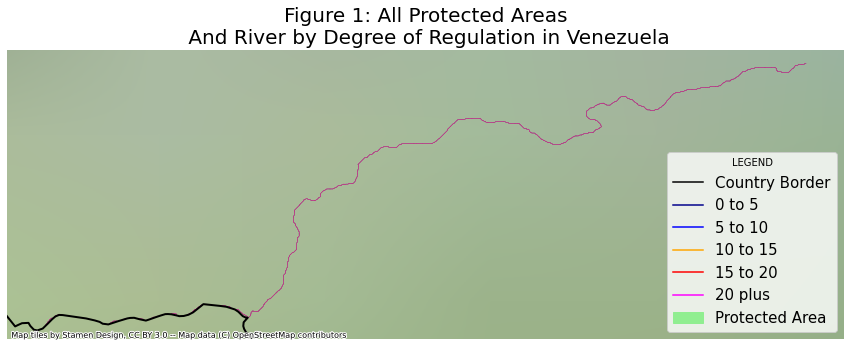

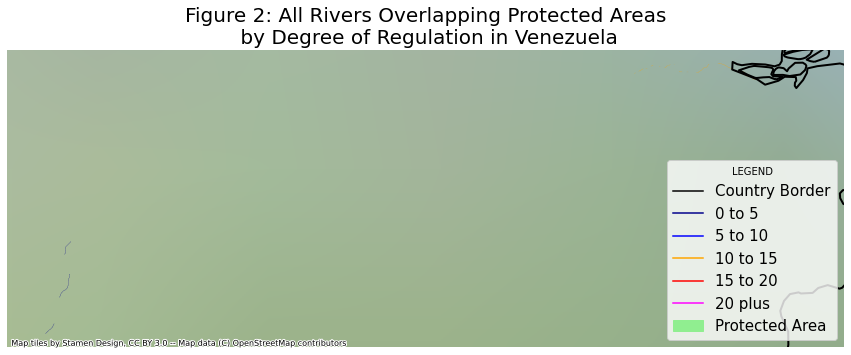

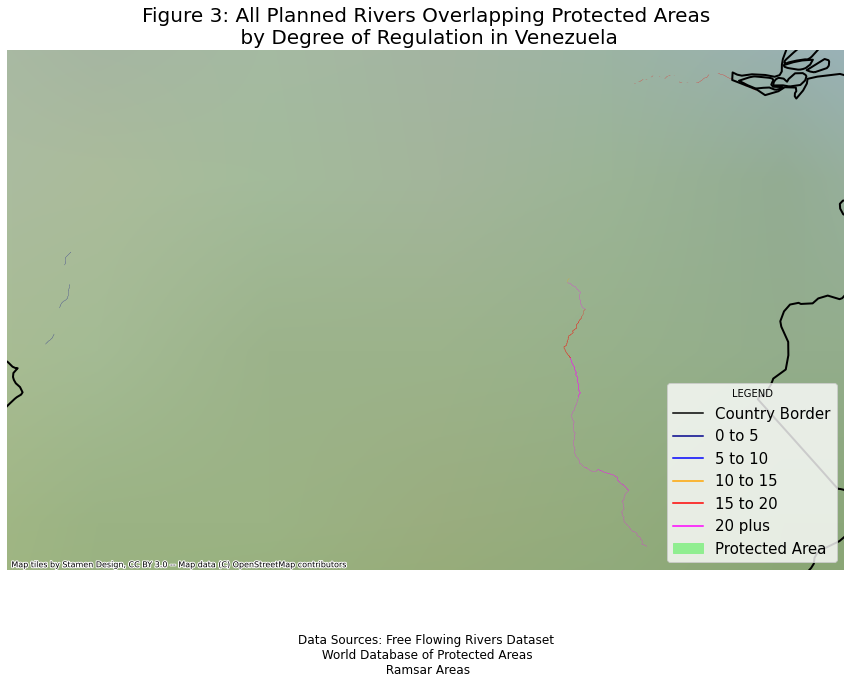

In [46]:
# Plot all rivers and all protected areas for Brazil
# Create legend
black_line = mlines.Line2D([], [], color='black', label='Country Border')
darkblue_line = mlines.Line2D([], [], color='darkblue', label='0 to 5')
blue_line = mlines.Line2D([], [], color='blue', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')

fig, ax1 = plt.subplots(figsize=(15, 15))
#wdpa_ramsar_ven.plot(ax=ax1, color="lightgreen")
all_rivers_0to5_ven.plot(ax=ax1,
                         markersize=15,
                         color='darkblue', legend=True)
all_rivers_5to10_ven.plot(ax=ax1,
                          markersize=15,
                          color='blue', legend=True)
all_rivers_10to15_ven.plot(ax=ax1,
                           markersize=15,
                           color='orange', legend=True)
all_rivers_15to20_ven.plot(ax=ax1,
                           markersize=15,
                           color='red', legend=True)
all_rivers_over20_ven.plot(ax=ax1,
                           markersize=15,
                           color='magenta', legend=True)
ctx.add_basemap(ax1, url=ctx.providers.Stamen.Terrain, zoom=0)
ven_border.plot(ax=ax1, color="none",  edgecolor="black", linewidth=2)
ax1.set_title(
    'Figure 1: All Protected Areas\n And River by Degree of Regulation in Venezuela', size=20)
ax1.set_axis_off()
ax1.legend(handles=[black_line, darkblue_line, blue_line, orange_line, red_line, magenta_line, lightgreen_patch],
           fontsize=15,
           frameon=True,
           loc=('lower right'),
           title="LEGEND")

# Plot all current rivers and that overlap protected areas for Brazil
fig, ax2 = plt.subplots(figsize=(15, 15))
#wdpa_ramsar_ven.plot(ax=ax2, color="lightgreen")
rivers_0to5_ven.plot(ax=ax2,
                     markersize=15,
                     color='darkblue', legend=True)
rivers_5to10_ven.plot(ax=ax2,
                      markersize=15,
                      color='blue', legend=True)
rivers_10to15_ven.plot(ax=ax2,
                       markersize=15,
                       color='orange', legend=True)
rivers_15to20_ven.plot(ax=ax2,
                       markersize=15,
                       color='red', legend=True)
rivers_over20_ven.plot(ax=ax2,
                       markersize=15,
                       color='magenta', legend=True)
ctx.add_basemap(ax2, url=ctx.providers.Stamen.Terrain, zoom=0)
ven_border.plot(ax=ax2, color="none",  edgecolor="black", linewidth=2)
ax2.set_title(
    'Figure 2: All Rivers Overlapping Protected Areas\n by Degree of Regulation in Venezuela', size=20)
ax2.set_axis_off()
ax2.legend(handles=[black_line, darkblue_line, blue_line, orange_line, red_line, magenta_line, lightgreen_patch],
           fontsize=15,
           frameon=True,
           loc=('lower right'),
           title="LEGEND")

# Plot all planned rivers and that overlap protected areas for Brazil
fig, ax3 = plt.subplots(figsize=(15, 15))
#wdpa_ramsar_ven.plot(ax=ax3, color="lightgreen")
rivers_pla_0to5_ven.plot(ax=ax3,
                         markersize=15,
                         color='darkblue', legend=True)
rivers_pla_5to10_ven.plot(ax=ax3,
                          markersize=15,
                          color='blue', legend=True)
rivers_pla_10to15_ven.plot(ax=ax3,
                           markersize=15,
                           color='orange', legend=True)
rivers_pla_15to20_ven.plot(ax=ax3,
                           markersize=15,
                           color='red', legend=True)
rivers_pla_over20_ven.plot(ax=ax3,
                           markersize=15,
                           color='magenta', legend=True)
ctx.add_basemap(ax3, url=ctx.providers.Stamen.Terrain, zoom=0)
ven_border.plot(ax=ax3, color="none",  edgecolor="black", linewidth=2)
ax3.set_title(
    'Figure 3: All Planned Rivers Overlapping Protected Areas\n by Degree of Regulation in Venezuela', size=20)
ax3.set_axis_off()

ax3.text(0.5, -0.2, "Data Sources: Free Flowing Rivers Dataset\n World Database of Protected Areas\n Ramsar Areas",
         size=12, ha="center", transform=ax3.transAxes)
ax3.legend(handles=[black_line, darkblue_line, blue_line, orange_line, red_line, magenta_line, lightgreen_patch],
           fontsize=15,
           frameon=True,
           loc=('lower right'),
           title="LEGEND")